In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')

with open("Lu_corpus.txt","r+") as f:
    Lu_corpus = f.read()

In [2]:
def count_words(doc):
    doc = doc.split()
    word_counts = dict.fromkeys(set(doc), 0)
    for word in doc:
        word_counts[word] += 1
        
    return word_counts

def plot_counts(word_counts, n_words=200, label_sample=5):    
    xticks_sample = range(0, n_words, label_sample)
    
    word_counts[:n_words].plot(
        figsize = (15, 10), 
        ylabel = "Count", 
        xlabel = "Word",
        xticks = xticks_sample,
        rot = 90
    )

In [3]:
# Remove punctuation, numbers
cleaned = re.sub(r"[-—]", " ", Lu_corpus.lower())
cleaned = re.sub(r"[^\w\s]", "", cleaned)
cleaned = re.sub(r"_", "", cleaned)
cleaned = re.sub(r"[0-9]", "", cleaned)

In [4]:
# Make a pd Series out of the text
cleaned_counts = pd.Series(cleaned.split()).value_counts()

In [5]:
# Remove stop words, i.e. 'the', 'where', 'one' etc.
nltk_stopwords = stopwords.words('english') # Get libary of stopwords from nltk 

to_remove = cleaned_counts.index.isin(nltk_stopwords)
stopped_counts = cleaned_counts[~to_remove]

#Remove two-letter words
stopped_counts = stopped_counts[stopped_counts.index.str.len() > 2]

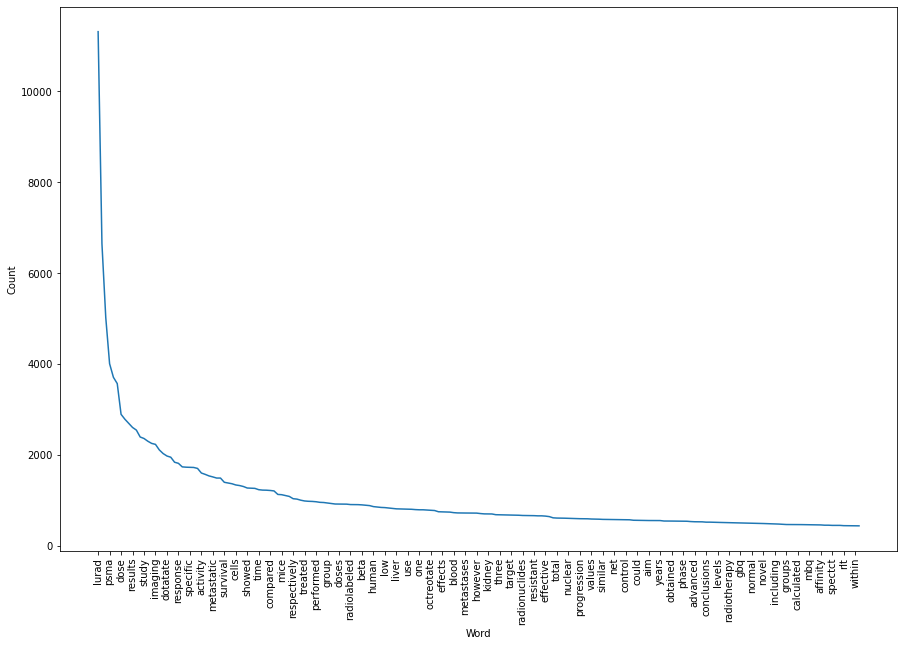

In [6]:
#Plot the distribution just for fun
plot_counts(stopped_counts, n_words=200, label_sample=3)

In [7]:
# Tag the words and put the result into a datframe
tagged = nltk.pos_tag(stopped_counts.index)
tagged_df = pd.DataFrame(tagged, columns = ['WORD', 'TAG'])

In [6]:
counts_df = pd.DataFrame(stopped_counts)

In [7]:
counts_df[['WORD','TAG']] = nltk.pos_tag(counts_df.index)

In [9]:
#Convert the tags into format that lemmatizer understands
lemmatizer = WordNetLemmatizer()

def convert_tag(tag):
    if tag.startswith('J'):
        tag = wordnet.ADJ
    elif tag.startswith('V'):
        tag = wordnet.VERB
    elif tag.startswith('N'):
        tag = wordnet.NOUN
    elif tag.startswith('R'):
        tag = wordnet.ADV
    else:
        tag = ''
    return tag

counts_df = counts_df.assign(NEW_TAG = counts_df['TAG'].apply(convert_tag))

In [11]:
#Lematize words, put the result into the dataframe
def lemmatize_word(word, new_tag):
    if new_tag != '':
        lemma = lemmatizer.lemmatize(word, pos = new_tag)
    else:
        lemma = lemmatizer.lemmatize(word)
    return lemma

counts_df = counts_df.assign(
    LEMMATIZED = counts_df.apply(lambda row: lemmatize_word(row['WORD'], row['NEW_TAG']), axis=1)
)

In [12]:
counts_df

,0,WORD,TAG,NEW_TAG,LEMMATIZED
lurad,11314,lurad,NN,n,lurad
patients,6649,patients,NNS,n,patient
therapy,5025,therapy,VBP,v,therapy
psma,4011,psma,JJ,a,psma
tumor,3712,tumor,NN,n,tumor
...,...,...,...,...,...
endocytosed,1,endocytosed,VBD,v,endocytosed
tricarboxy,1,tricarboxy,JJ,a,tricarboxy
acety,1,acety,NN,n,acety
oetreotide,1,oetreotide,IN,,oetreotide


In [14]:
lemmtzd_df = counts_df.groupby('LEMMATIZED').sum()
lemmtzd_df.columns = ['Count']

In [26]:
lemmtzd_out_df = lemmtzd_df[lemmtzd_df.Count > 10].sort_values('Count', axis = 0, ascending = False)

In [27]:
lemmtzd_out_df.to_excel('corpus.xls')

/tmp/ipykernel_11132/2150491366.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  lemmtzd_out_df.to_excel('corpus.xls')
